# Caderno 4 - Calcula métricas considerando os resultados de pesquisa em um BM25 padrão

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_ENUNCIADO_EXCERTO = False

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/4_metricas_bm25_padrao/'
NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto.pickle'

## 1. Carrega base de dados

Carrega a lista de documentos para indexar, as queries para testar e o qrels.

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

## 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO

In [3]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt_remove_html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\santosr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santosr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\santosr\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [4]:
import os

# Vamos criar um índice invertido e indexar apenas o enunciado e excerto.
iidx = IndiceInvertido(tokenizador_pt_remove_html)

if REINDEXAR_ENUNCIADO_EXCERTO or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO):
    # Se for indexar a primeira vez:
    # Demora cerca de 35 minutos para indexar
    iidx.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO']))
    iidx.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO)
else:
    # Se quiser recuperar de um arquivo:
    iidx.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_E_EXCERTO)

In [5]:
print(iidx.get_tamanho_medio_docs())

476.4924275475226


In [6]:
# Agora instancia um BM25
buscador = BM25(iidx, k1=1.2, b=0.75, bias_idf=1)

## 3. Faz as pesquisas e salva os resultados

In [7]:
col_resultado_query_key=[]
col_resultado_doc_key=[]
col_resultado_rank=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    resultados = buscador.pesquisar(query_text)

    primeiros_50_docs = [tupla_key_score[0] for tupla_key_score in resultados[:50]]
    queries_keys = [query_key] * len(primeiros_50_docs)
    ranking = list(range(1, len(primeiros_50_docs)+1))

    col_resultado_query_key.extend(queries_keys)
    col_resultado_doc_key.extend(primeiros_50_docs)
    col_resultado_rank.extend(ranking)

df_resultados = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key,
    "DOC_KEY": col_resultado_doc_key,
    "RANK": col_resultado_rank,
})

In [8]:
from metricas import metricas

df_metricas = metricas(df_resultados, qrels, aproximacao_trec_eval=True)

In [9]:
import pickle

# Gravando lote em um arquivo .pickle
caminho_arquivo_metricas = f'{PASTA_RESULTADO_CADERNO}metricas_bm25.pickle'
with open(caminho_arquivo_metricas, 'wb') as arquivo_pickle:
    pickle.dump(df_metricas, arquivo_pickle)

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.272000,0.238000,0.209000,0.121600,0.110636,0.196569,0.347308,0.500614,0.525333,0.538627,0.544551,0.546937,0.282379,0.275298,0.352540,0.426195
std,14.57738,0.244982,0.179444,0.124822,0.055673,0.099343,0.154812,0.221556,0.257299,0.432564,0.417731,0.410380,0.407224,0.255681,0.218524,0.224902,0.227578
min,1.00000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.025004
25%,13.25000,0.050000,0.100000,0.112500,0.060000,0.016667,0.071429,0.175000,0.235577,0.050000,0.157143,0.157143,0.157143,0.021868,0.081723,0.176122,0.260533
50%,25.50000,0.200000,0.200000,0.225000,0.120000,0.083333,0.190909,0.363636,0.461538,0.500000,0.500000,0.500000,0.500000,0.231560,0.238329,0.346441,0.447529
75%,37.75000,0.400000,0.375000,0.250000,0.160000,0.166667,0.296429,0.454545,0.710714,1.000000,1.000000,1.000000,1.000000,0.470365,0.420690,0.520625,0.608422
max,50.00000,1.000000,0.700000,0.500000,0.200000,0.384615,0.571429,0.800000,0.909091,1.000000,1.000000,1.000000,1.000000,0.975055,0.813430,0.805415,0.818951


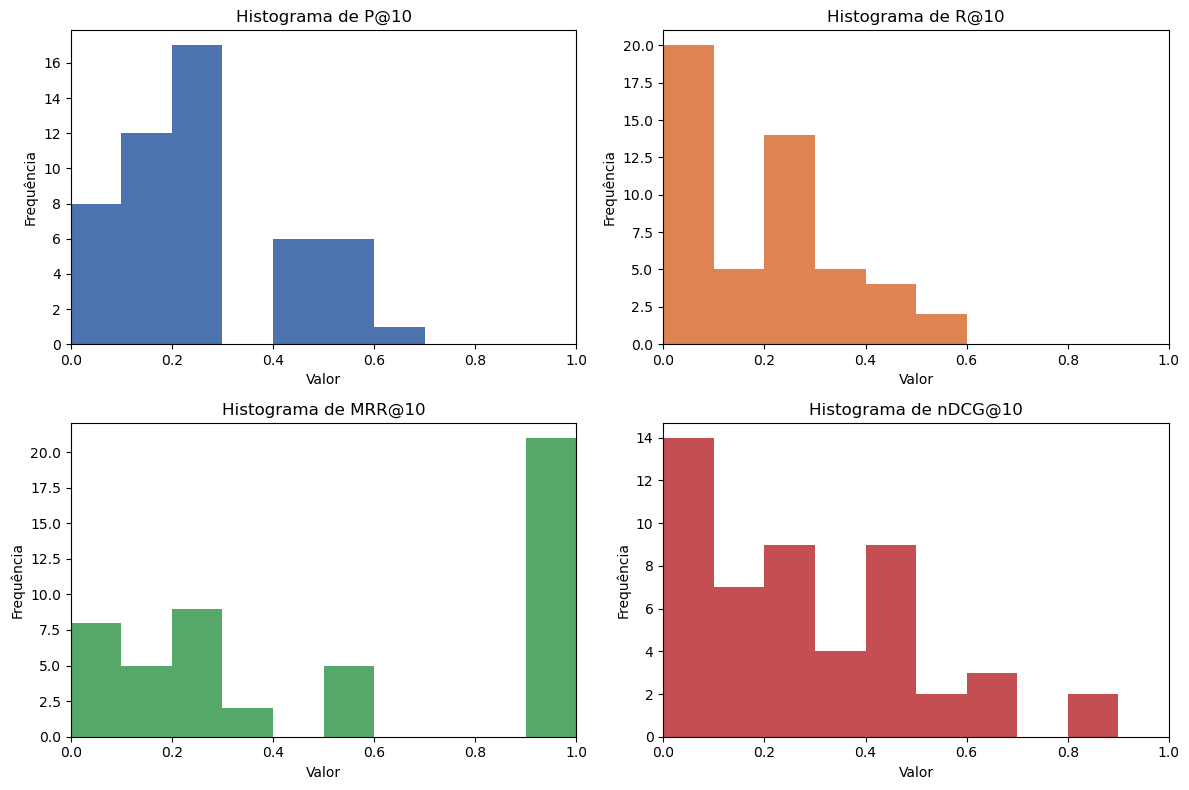

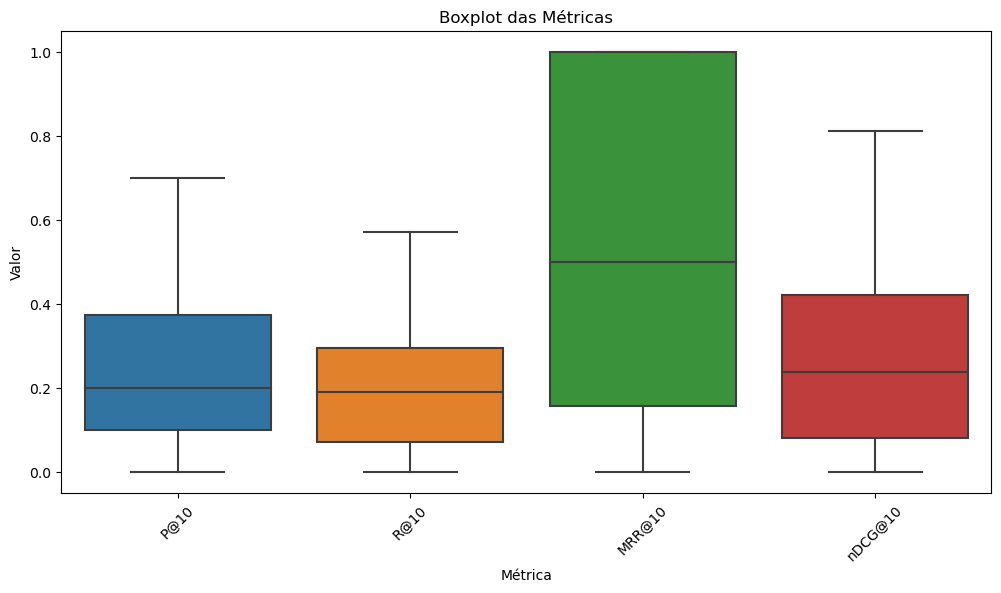

In [10]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries:
display(df_metricas[0:50].describe())
histograma_metricas(df_metricas[0:50])
boxplot_metricas(df_metricas[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.00000,50.00000,50.00000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.500000,0.378000,0.271000,0.141600,0.207719,0.317636,0.453818,0.590441,0.86200,0.86650,0.86650,0.86650,0.571279,0.510644,0.561789,0.621719
std,14.57738,0.256348,0.191972,0.122512,0.048122,0.108592,0.174833,0.221256,0.219515,0.29339,0.28047,0.28047,0.28047,0.228640,0.187619,0.189599,0.176897
min,51.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.071429,0.076923,0.083333,0.00000,0.10000,0.10000,0.10000,0.000000,0.054163,0.122265,0.122265
25%,63.25000,0.400000,0.200000,0.162500,0.105000,0.153846,0.224359,0.285714,0.428571,1.00000,1.00000,1.00000,1.00000,0.463210,0.388955,0.461444,0.539758
50%,75.50000,0.400000,0.400000,0.300000,0.150000,0.198052,0.285714,0.461538,0.591667,1.00000,1.00000,1.00000,1.00000,0.596233,0.530920,0.575941,0.640213
75%,87.75000,0.600000,0.500000,0.350000,0.180000,0.293182,0.425595,0.583333,0.750000,1.00000,1.00000,1.00000,1.00000,0.722727,0.636528,0.665975,0.714008
max,100.00000,1.000000,0.800000,0.500000,0.200000,0.454545,0.800000,0.900000,1.000000,1.00000,1.00000,1.00000,1.00000,1.000000,0.832815,0.913779,0.944688


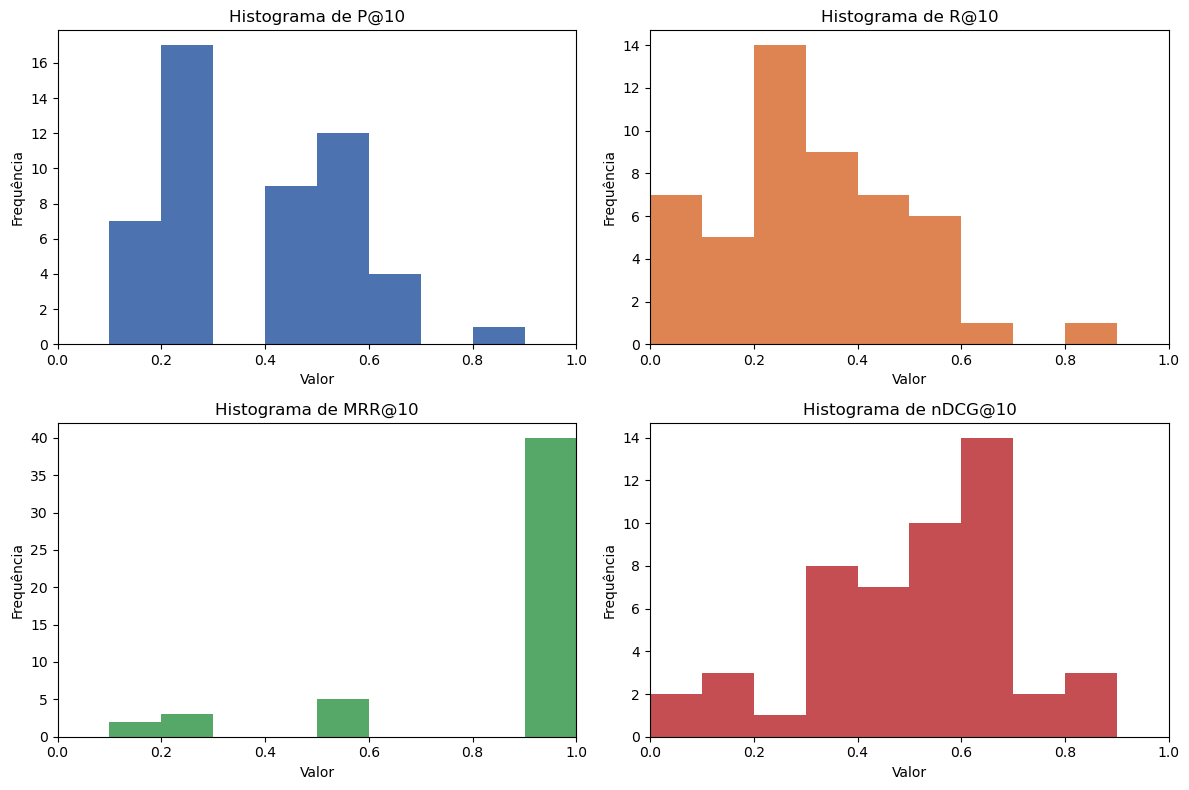

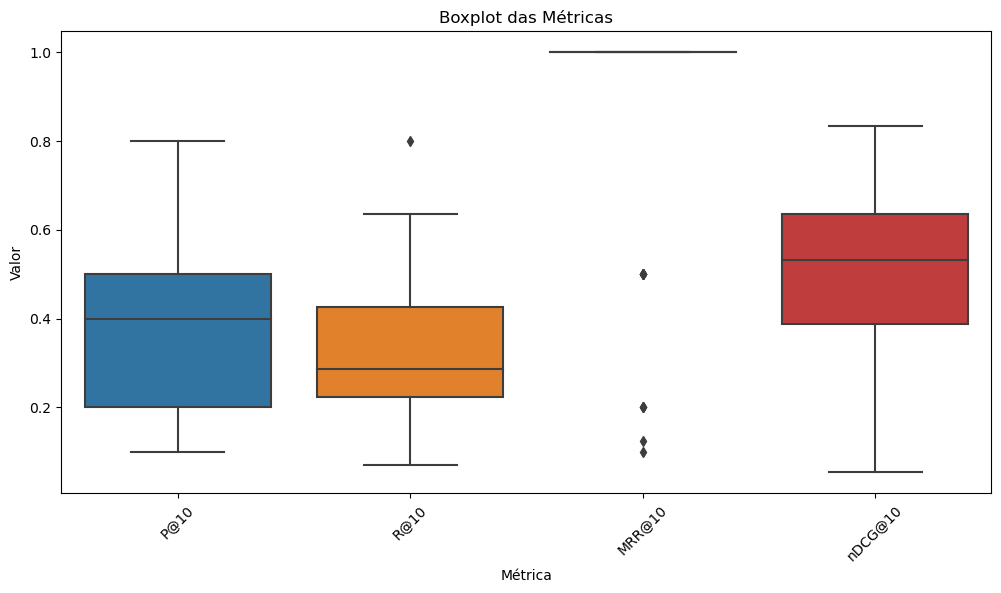

In [11]:
# Resultados para o primeiro grupo de queries:
display(df_metricas[50:100].describe())
histograma_metricas(df_metricas[50:100])
boxplot_metricas(df_metricas[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.520000,0.388000,0.26900,0.138000,0.234018,0.345062,0.476209,0.607686,0.915000,0.917500,0.917500,0.917500,0.603006,0.532787,0.586733,0.642099
std,14.57738,0.239046,0.174543,0.12075,0.051627,0.116894,0.157637,0.216961,0.225326,0.223664,0.213705,0.213705,0.213705,0.200211,0.160102,0.172152,0.163933
min,101.00000,0.000000,0.100000,0.05000,0.020000,0.000000,0.066667,0.100000,0.100000,0.000000,0.125000,0.125000,0.125000,0.000000,0.074372,0.276223,0.317375
25%,113.25000,0.400000,0.300000,0.16250,0.105000,0.166667,0.235577,0.308333,0.461538,1.000000,1.000000,1.000000,1.000000,0.497633,0.458046,0.464914,0.499143
50%,125.50000,0.400000,0.400000,0.25000,0.140000,0.214286,0.333333,0.480769,0.625874,1.000000,1.000000,1.000000,1.000000,0.574628,0.534461,0.599735,0.631617
75%,137.75000,0.600000,0.500000,0.35000,0.180000,0.300000,0.454545,0.595833,0.750000,1.000000,1.000000,1.000000,1.000000,0.733366,0.619033,0.737977,0.779565
max,150.00000,1.000000,0.700000,0.50000,0.220000,0.500000,0.636364,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.807556,0.938127,0.938127


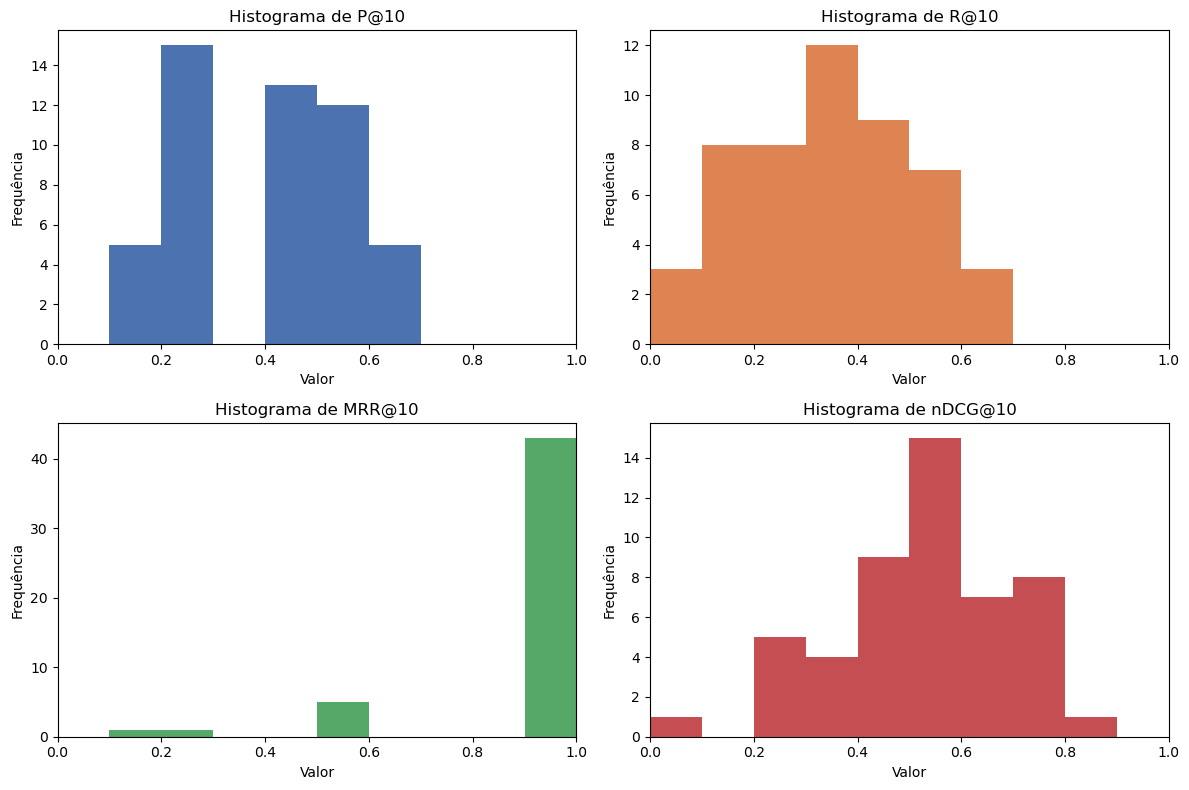

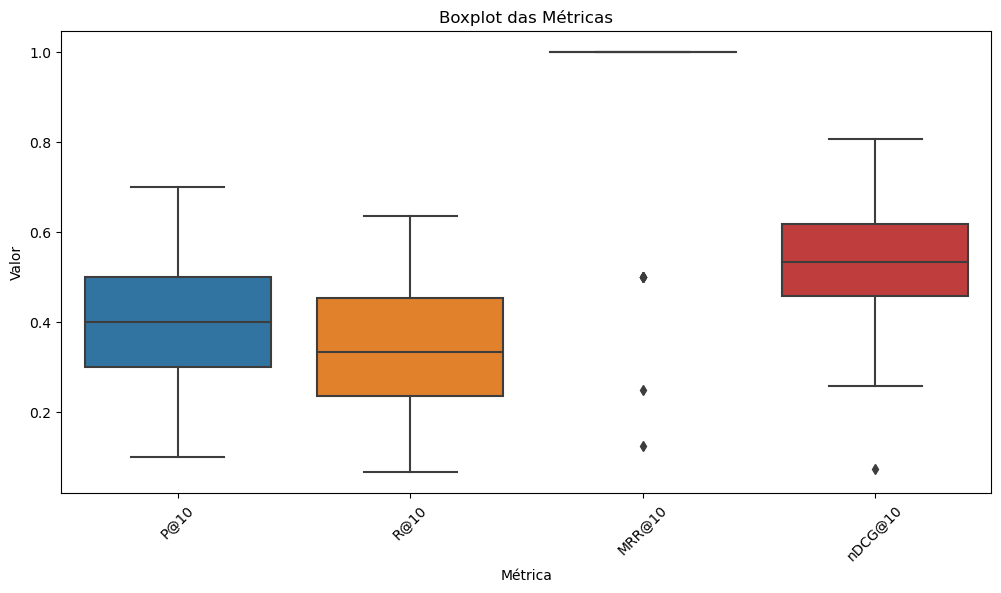

In [12]:
# Resultados para o primeiro grupo de queries:
display(df_metricas[100:150].describe())
histograma_metricas(df_metricas[100:150])
boxplot_metricas(df_metricas[100:150])